## Notebook to explore the performance of different toy models of superposition across various sparsity levels

Toy models: 
1. Simple - ReLU(x)
2. Simple - Relu(x) (handcoded, Lucius)
3. Apollo: Residual + Embedding
4. Anthropic: abs(x)

Sparsity levels: 



In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response


In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

In [3]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [4]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

## 1. Simple ReLU

MLP that computes: $y = ReLU(x)$

Architecture: 100 input features for 50 neurons in a single layer. 

Loss function: MSE (not weighted for now)

Input: 100 features with a sparsity S =0.99, meaning that any given feature has p = 0.01 of being active, where `x = rand(-1,1)`

In [5]:
# 1. Training functions
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [6]:
layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

relu_cis = Cis(simple_relu_cfg, device=device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 100
optimizer = t.optim.Adam(relu_cis.parameters())

losses = train(
    relu_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.0018724738620221615,
 0.0017675018170848489,
 0.0015262296656146646,
 0.0011891120811924338,
 0.001295091351494193,
 0.001054489752277732,
 0.0011139509733766317,
 0.0011164451716467738,
 0.001081735361367464,
 0.0009670417639426887,
 0.0009623620426282287,
 0.0008315122686326504,
 0.0008614838006906211,
 0.0008801102521829307,
 0.0010021221823990345,
 0.0010031010024249554,
 0.0008006187854334712,
 0.0009799371473491192,
 0.0009596689487807453,
 0.0008488265448249876,
 0.0010375436395406723,
 0.0009562857449054718,
 0.0008385468972846866,
 0.0008176357951015234,
 0.0009036229457706213,
 0.000937286822590977,
 0.0010942103108391166,
 0.0006826024618931115,
 0.0009997113374993205,
 0.0008676826837472618,
 0.0008691250113770366,
 0.0009758271626196802,
 0.0008181261946447194,
 0.0008643023320473731,
 0.0008664511842653155,
 0.0010142810642719269,
 0.000766179000493139,
 0.0007042789366096258,
 0.0007522827363573015,
 0.0009528941591270268,
 0.0008323946385644376,
 0.000943550607189536

In [38]:
"""Get polysemanticity and loss for set of sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    relu_cis = Cis(simple_relu_cfg, device=device).to(device)
    optimizer = t.optim.Adam(relu_cis.parameters())
    losses = train(
        relu_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / relu_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(relu_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, relu_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(relu_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                relu_cis.cfg.n_instances, 
                relu_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = relu_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

In [22]:
"""Import a couple more things for plotting"""

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

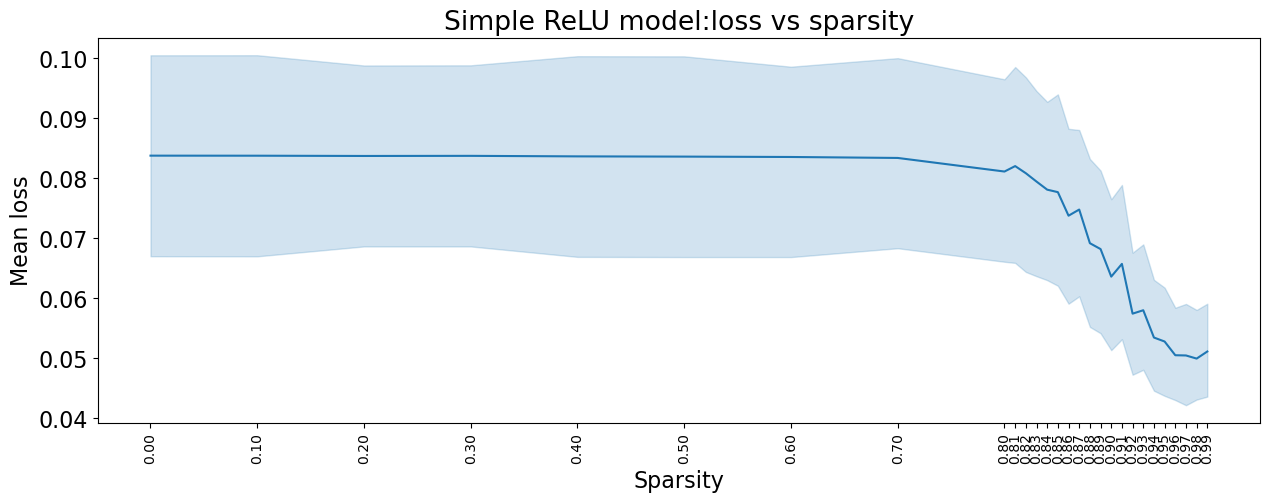

In [40]:
"""Plot loss vs sparsity for the simple ReLU model - use 20 datapoints"""

# Convert loss_data to pandas dataframe for ease of plotting with seaborn
df_loss = pd.DataFrame(loss_data)

# Create figure of all sparsity values
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data = df_loss, x = "sparsity", y = "mean_loss")
plt.xlabel('Sparsity')
plt.xticks(sparsities, fontsize=10, rotation = 90)
plt.ylabel('Mean loss')
plt.title('Simple ReLU model:loss vs sparsity')
plt.show()


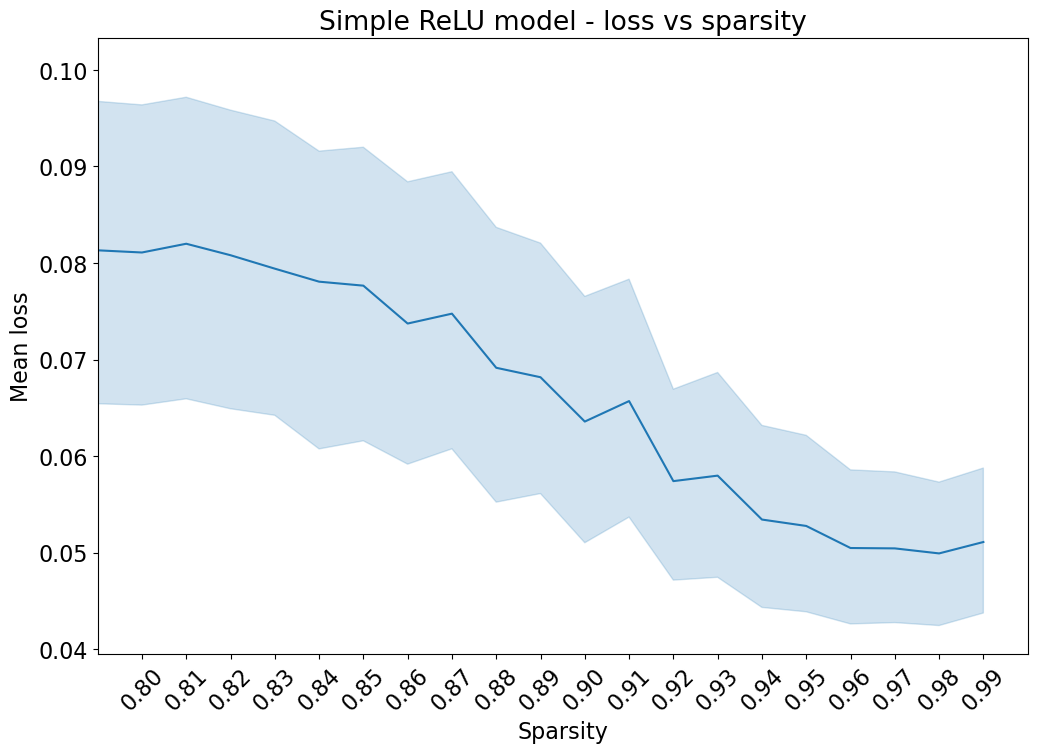

In [44]:
# Create figure of high sparsity values
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data = df_loss, x = "sparsity", y = "mean_loss")
plt.xlabel('Sparsity')
plt.xlim(0.79,1)
plt.xticks(sparsities[sparsities > 0.75], rotation = 45)
plt.ylabel('Mean loss')
plt.title('Simple ReLU model - loss vs sparsity')
plt.show()